In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

## Read in weather data

In [2]:
#read the weather data file

df_weather = pd.read_csv('weather_edit.csv')

In [3]:
df_weather.head()

,pickup_datetime,tempm,precipm,conds,precip_type
0,2016/01/01 00:51:00,5.6,NaN,Overcast,NaN
1,2016/01/01 01:51:00,5.0,NaN,Overcast,NaN
2,2016/01/01 02:51:00,5.0,NaN,Overcast,NaN
3,2016/01/01 03:51:00,5.0,NaN,Overcast,NaN
4,2016/01/01 04:51:00,4.4,NaN,Overcast,NaN


In [4]:
#fill the None entries in precip_type with an empty string

df_weather.precip_type = df_weather['precip_type'].fillna('')

In [5]:
#fill the None entries in precipm with 0

df_weather.precipm = df_weather.precipm.fillna(0)

In [6]:
%%time
df_weather['pickup_datetime'] = pd.to_datetime(df_weather.pickup_datetime)

CPU times: user 11 ms, sys: 3.75 ms, total: 14.7 ms
Wall time: 22 ms


In [7]:
#create a month column, and a day column

df_weather['month'] = df_weather.pickup_datetime.dt.month
df_weather['day'] = df_weather.pickup_datetime.dt.day

In [8]:
df_weather.head()

,pickup_datetime,tempm,precipm,conds,precip_type,month,day
0,2016-01-01 00:51:00,5.6,0.0,Overcast,,1,1
1,2016-01-01 01:51:00,5.0,0.0,Overcast,,1,1
2,2016-01-01 02:51:00,5.0,0.0,Overcast,,1,1
3,2016-01-01 03:51:00,5.0,0.0,Overcast,,1,1
4,2016-01-01 04:51:00,4.4,0.0,Overcast,,1,1


In [9]:
cols = ['month', 'day', 'conds', 'precip_type', 'precipm', 'tempm']
df_weather = df_weather[cols]

In [10]:
#create a dataframe of how many measurements of each instance were taken
#one column for rain, one for snow, one for nothing

weather_grouped = df_weather.groupby(['month','day'])

raincount = []
snowcount = []
count = []

for month, day in weather_grouped:
    raincount.append(day.loc[day.precip_type == 'rain', 'precip_type'].count())
    snowcount.append(day.loc[day.precip_type == 'snow', 'precip_type'].count())
    count.append(day.loc[day.precip_type == '', 'precip_type'].count())

    

In [11]:
df_precip_type = pd.DataFrame({'rain':raincount, 'snow':snowcount, 'clear':count})

In [12]:
#for each day, total up the number of instances that the weather was measured
#add up the total instances or snow and rain
#if it either snowed / rained for more that 20% of that day, treat that day as having snowed / rained respectively

for i,k in df_precip_type.iterrows():
    rain = df_precip_type.loc[i,'rain']
    snow = df_precip_type.loc[i,'snow']
    clear = df_precip_type.loc[i,'clear']
    total = rain + snow + clear
    
    if snow/total >= 0.20:
        df_precip_type.loc[i,'precip_type'] = 'snow'
    elif rain/total >= 0.20:
        df_precip_type.loc[i,'precip_type'] = 'rain'
    else:
        df_precip_type.loc[i,'precip_type'] = ''

In [13]:
df_precip_type.head(10)

,rain,snow,clear,precip_type
0,0,0,24,
1,1,0,23,
2,0,0,26,
3,1,0,18,
4,11,0,28,rain
5,0,0,24,
6,9,0,29,rain
7,2,0,38,
8,12,0,19,rain
9,0,0,30,


In [14]:
#group the dataframe by month, day
#sum the precipm, average the tempm

df_weather_grouped = df_weather.groupby(['month', 'day']).agg({'precipm':sum, 'tempm':'mean'})

In [15]:
df_weather_grouped.head()

precipm      tempm
month day                    
1     1        0.0   3.766667
      2        0.3  10.695833
      3        0.0   7.730769
      4        0.3  20.515789
      5        6.3   8.792308

In [16]:
#assign the precip aggregated by day to the grouped dataframe

df_weather_grouped['precip_type'] = df_precip_type['precip_type'].to_list()

In [17]:
df_weather_grouped.head(10)

precipm      tempm precip_type
month day                                
1     1        0.0   3.766667            
      2        0.3  10.695833            
      3        0.0   7.730769            
      4        0.3  20.515789            
      5        6.3   8.792308        rain
      6        0.0  23.616667            
      7       81.5  22.502632        rain
      8        2.1  22.562500            
      9       20.5  22.490323        rain
      10       0.0  14.756667

In [18]:
#get a listing of all the days that it snowed grouped by month

snow_days = df_weather_grouped.groupby('precip_type').get_group('snow')
snow_days

precipm     tempm precip_type
month day                               
1     17       1.6  1.311765        snow
      23      85.9 -3.495556        snow
2     15      19.8 -3.045652        snow
3     20       2.9  1.940541        snow
      21       6.9  2.621951        snow
4     3        7.5 -0.091071        snow
5     2       19.5  0.893182        snow
8     2        4.6  0.634091        snow
11    12       1.3 -0.478125        snow
12    17      36.3 -0.204878        snow

In [19]:
snow_dict = {}
for i in snow_days.index:
    snow_dict[i] = weather_grouped.get_group(i)['precip_type'].value_counts()


In [20]:
df_snow = pd.DataFrame.from_dict(snow_dict)
df_snow = df_snow.transpose()

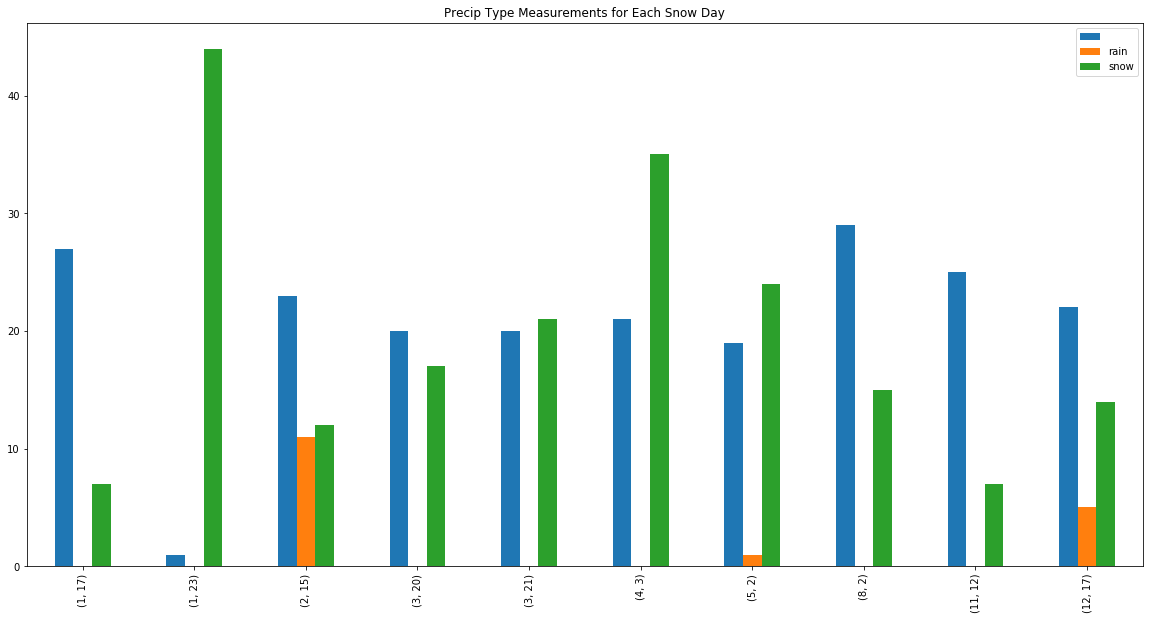

In [21]:
df_snow.plot(kind = 'bar', figsize = (20,10), title = 'Precip Type Measurements for Each Snow Day')

In [22]:
#get a listing of all the days that it rained grouped by month

rain_days = df_weather_grouped.groupby('precip_type').get_group('rain')
rain_days

precipm      tempm precip_type
month day                                
1     5        6.3   8.792308        rain
      7       81.5  22.502632        rain
      9       20.5  22.490323        rain
      16      14.4   7.120000        rain
2     3        6.9   6.174074        rain
      16      38.1   9.326667        rain
      24      72.3   7.322535        rain
3     2       37.1  11.595122        rain
      5       40.7  11.440000        rain
      14      13.5   6.526471        rain
      28      22.6   7.932609        rain
4     4       16.0   3.430435        rain
      7       11.8  22.651724        rain
      23       8.6  17.354839        rain
      26      11.8  11.675000        rain
5     6       54.7  19.351064        rain
      7       81.1  23.551064        rain
      12       6.2   6.090909        rain
      24       5.5  17.868000        rain
      30     105.1  22.242857        rain
6     5       39.0   9.728571        rain
      16      12.3  20.480645        rain
7     25      76.6  26.215385        rain
      29      94.5  23.291489        rain
      30      14.5  24.019149        rain
      31      33.1  23.750000        rain
8     6       24.7  15.186667        rain
      10      10.5  18.005128        rain
      20      30.5  24.440000        rain
9     7       23.7  20.140541        rain
      10      20.6  14.160526        rain
      19      28.0  21.916327        rain
      24      15.0  17.152941        rain
      27       8.7  19.615152        rain
      30      14.5  14.410811        rain
10    1      110.4  10.273913        rain
      21      55.0  19.484127        rain
      22      13.8   9.910811        rain
      27      82.0   8.973469        rain
      30      17.3  16.994286        rain
11    15     131.8   9.440000        rain
      19      10.1  11.663889        rain
      29     116.5  14.022222        rain
      30      37.6  11.831915        rain
12    4        5.1  11.325000        rain
      8       23.4  27.082353        rain
      12      22.6   4.527778        rain
      24      22.4   5.297500        rain
      29      19.7   5.343902        rain

In [23]:
rain_dict = {}
for i in rain_days.index:
    rain_dict[i] = weather_grouped.get_group(i)['precip_type'].value_counts()


In [24]:
df_rain = pd.DataFrame.from_dict(rain_dict)
df_rain = df_rain.transpose()

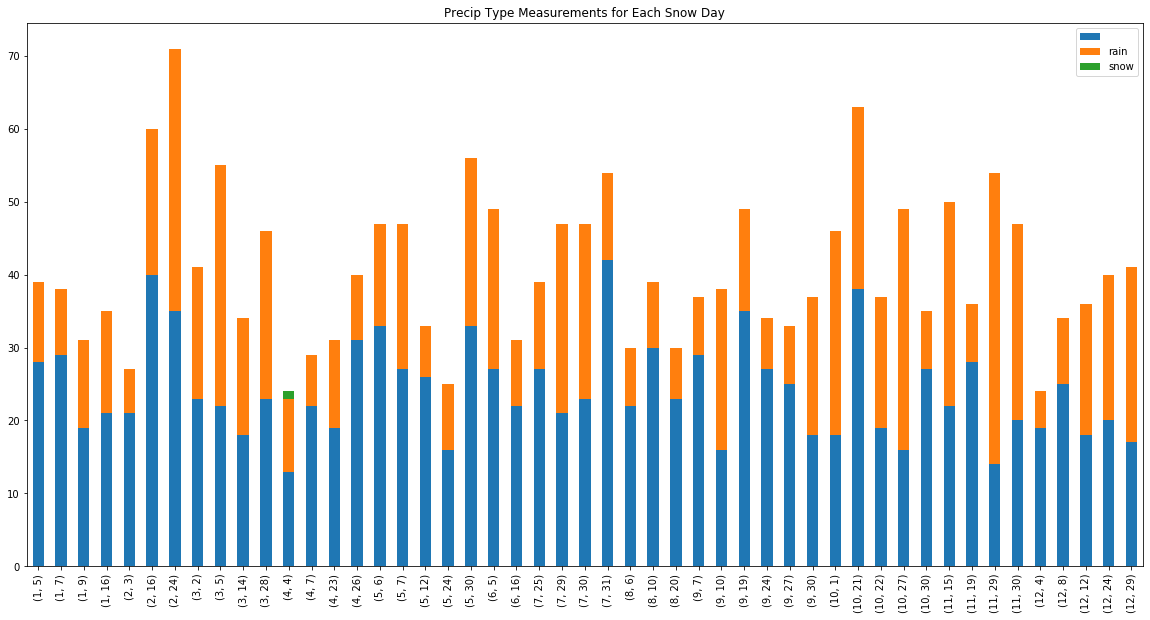

In [25]:
df_rain.plot(kind = 'bar', stacked = True, figsize = (20,10), title = 'Precip Type Measurements for Each Snow Day')

Text(0, 0.5, 'Precip in mm')

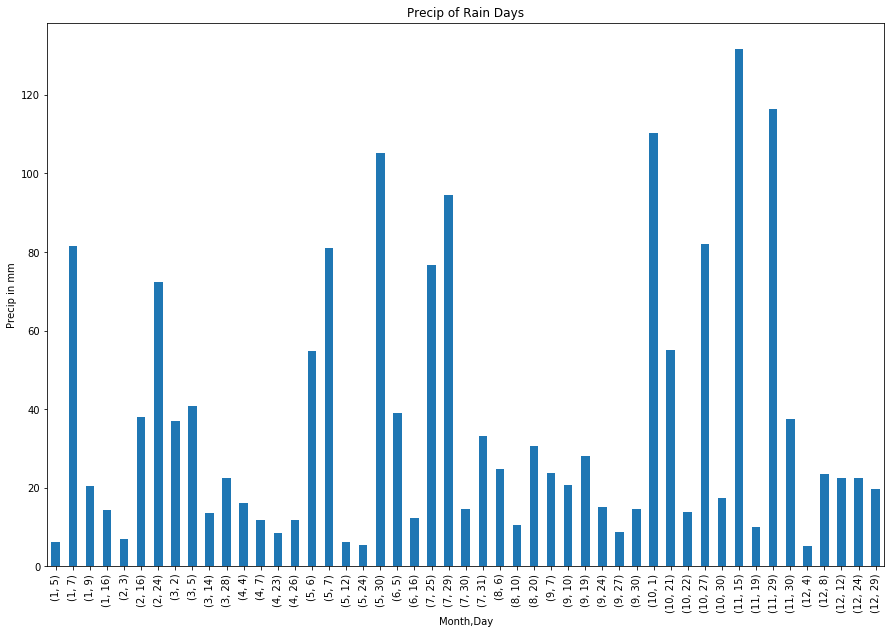

In [26]:
rain_days['precipm'].plot(kind='bar', figsize = (15,10), title = 'Precip of Rain Days')
plt.xlabel('Month,Day')
plt.ylabel('Precip in mm')

In [27]:
#reset the index of the grouped weather dataframe
#group by month, and filter for the precip_type column, and count the values
#see how many days it rained and snowed

df_weather_grouped.reset_index().groupby('month')['precip_type'].value_counts()

month  precip_type
1                     25
       rain            4
       snow            2
2                     25
       rain            3
       snow            1
3                     25
       rain            4
       snow            2
4                     25
       rain            4
       snow            1
5                     25
       rain            5
       snow            1
6                     28
       rain            2
7                     27
       rain            4
8                     27
       rain            3
       snow            1
9                     24
       rain            6
10                    26
       rain            5
11                    25
       rain            4
       snow            1
12                    25
       rain            5
       snow            1
Name: precip_type, dtype: int64

### From this we can arbitrarily choose which months we want to sample from the taxi data
### We would like months where there are more instances of rain and snow with a variety of precipitation levels.
### Choose months 1 since it snowed twice, as well as 9 since that months had the most rainy days (6)
### Months = 1,  9

In [28]:
monthlist = [1,9]
weather = []
for i in monthlist:
    weather.append(df_weather_grouped.reset_index().groupby('month').get_group(i))

In [29]:
df_weather_months = pd.concat(weather)

In [30]:
df_weather_months.head()

,month,day,precipm,tempm,precip_type
0,1,1,0.0,3.766667,
1,1,2,0.3,10.695833,
2,1,3,0.0,7.730769,
3,1,4,0.3,20.515789,
4,1,5,6.3,8.792308,rain


In [31]:
df_weather_months.tail()

,month,day,precipm,tempm,precip_type
269,9,26,0.0,17.816667,
270,9,27,8.7,19.615152,rain
271,9,28,0.0,17.558621,
272,9,29,0.0,16.025000,
273,9,30,14.5,14.410811,rain


## Read in taxi data

In [32]:
#read in the edited taxi data
chunklist = []
for chunk in pd.read_csv('taxi_edit.csv', chunksize = 100000):
    chunklist.append(chunk)

In [33]:
df_taxi = pd.concat(chunklist)

In [34]:
df_taxi.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,DOLocationID,speed
0,02/22/2016 06:14:21 PM,02/22/2016 06:27:21 PM,4.4,NaN,NaN,20.307692
1,02/10/2016 05:51:14 PM,02/10/2016 05:58:34 PM,1.1,NaN,NaN,9.000000
2,02/13/2016 02:56:14 PM,02/13/2016 03:13:35 PM,6.6,NaN,NaN,22.824207
3,02/15/2016 01:29:39 PM,02/15/2016 01:45:53 PM,2.2,NaN,NaN,8.131417
4,02/27/2016 11:59:52 PM,02/28/2016 12:04:18 AM,1.2,NaN,NaN,16.240602


In [35]:
%%time
#convert pickup_datetime string to datetime 
df_taxi.loc[:,'tpep_pickup_datetime'] = df_taxi.tpep_pickup_datetime.astype('datetime64[ns]')

CPU times: user 2h 22min 48s, sys: 1min 11s, total: 2h 24min
Wall time: 2h 26min 1s


In [36]:
%%time
#convert dropoff_datetime string to datetime
df_taxi.loc[:,'tpep_dropoff_datetime'] = df_taxi.tpep_dropoff_datetime.astype('datetime64[ns]')

CPU times: user 2h 20min 49s, sys: 59.2 s, total: 2h 21min 48s
Wall time: 2h 23min 3s


In [37]:
#drop the pickup and dropoff locations since we will not be using them

df_taxi = df_taxi.drop(columns = ['PULocationID', 'DOLocationID'])

In [38]:
#drop the rows that have None values

df_taxi.dropna()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,speed
0,2016-02-22 18:14:21,2016-02-22 18:27:21,4.4,20.307692
1,2016-02-10 17:51:14,2016-02-10 17:58:34,1.1,9.000000
2,2016-02-13 14:56:14,2016-02-13 15:13:35,6.6,22.824207
3,2016-02-15 13:29:39,2016-02-15 13:45:53,2.2,8.131417
4,2016-02-27 23:59:52,2016-02-28 00:04:18,1.2,16.240602
...,...,...,...,...
60966608,2016-09-07 15:03:33,2016-09-07 16:19:37,17.9,14.119194
60966609,2016-11-18 00:54:11,2016-11-18 01:07:44,2.9,12.841328
60966610,2016-12-09 00:22:50,2016-12-09 00:58:54,8.5,14.140481
60966611,2016-10-01 02:24:03,2016-10-01 02:35:39,3.8,19.655172


## Get months 1 and 9 from the df_taxi dataset

In [39]:
df_taxi.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,speed
0,2016-02-22 18:14:21,2016-02-22 18:27:21,4.4,20.307692
1,2016-02-10 17:51:14,2016-02-10 17:58:34,1.1,9.000000
2,2016-02-13 14:56:14,2016-02-13 15:13:35,6.6,22.824207
3,2016-02-15 13:29:39,2016-02-15 13:45:53,2.2,8.131417
4,2016-02-27 23:59:52,2016-02-28 00:04:18,1.2,16.240602


In [40]:
#group the taxi data by month

df_taxi_bymonth = df_taxi.groupby(df_taxi['tpep_pickup_datetime'].dt.month)

In [41]:
#create a list of the taxi dataframes by month groups 1, 9 as chosen earlier

df = []
for i in monthlist:
    df.append(df_taxi_bymonth.get_group(i))
    

In [42]:
#combine the list into a dataframe

df = pd.concat(df)

In [43]:
df.tail()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,speed
60966595,2016-09-18 20:28:26,2016-09-18 20:32:05,0.9,14.794521
60966597,2016-09-20 03:14:09,2016-09-20 03:32:51,7.2,23.101604
60966606,2016-09-20 00:40:09,2016-09-20 01:00:39,6.1,17.853659
60966607,2016-09-12 16:54:03,2016-09-12 17:00:41,1.1,9.949749
60966608,2016-09-07 15:03:33,2016-09-07 16:19:37,17.9,14.119194


In [44]:
#convert the pickup time into a datetime object with just the date (no time)

df.loc[:,'tpep_pickup_datetime'] = df.loc[:,'tpep_pickup_datetime'].dt.date

In [45]:
#rename the column 'tpep_pickup_datetime' as 'date'

df = df.rename(columns = {'tpep_pickup_datetime':'date'})

In [46]:
#drop the dropoff datetime column

df = df.drop(columns = 'tpep_dropoff_datetime')

In [47]:
df.head()

,date,trip_distance,speed
354051,2016-01-19,1.1,7.266055
374383,2016-01-11,0.7,8.428094
376216,2016-01-30,11.4,17.236455
376217,2016-01-10,4.3,22.500000
376218,2016-01-04,0.4,9.729730


### To merge the two dataframes we need to have the date columns that can be joined on

In [48]:
#create a new date column that concats the month and day into a single date string

for i in df_weather_months.index:
    df_weather_months.loc[i,'date'] = str(df_weather_months.loc[i,'month']) + '/' + str(df_weather_months.loc[i,'day']) + '/2016'

In [49]:
df_weather_months.head()

,month,day,precipm,tempm,precip_type,date
0,1,1,0.0,3.766667,,1/1/2016
1,1,2,0.3,10.695833,,1/2/2016
2,1,3,0.0,7.730769,,1/3/2016
3,1,4,0.3,20.515789,,1/4/2016
4,1,5,6.3,8.792308,rain,1/5/2016


In [50]:
#convert the date column to a datetime object with the month, day, year

df_weather_months.loc[:,'date'] = df_weather_months.loc[:,'date'].astype('datetime64[ns]').dt.date

In [51]:
#drop the month and day column, since we now have a date column

df_weather_months = df_weather_months.drop(columns = ['month', 'day'])

In [52]:
df_weather_months = df_weather_months[['date','precip_type','precipm','tempm']]

In [53]:
df_weather_months.tail()

,date,precip_type,precipm,tempm
269,2016-09-26,,0.0,17.816667
270,2016-09-27,rain,8.7,19.615152
271,2016-09-28,,0.0,17.558621
272,2016-09-29,,0.0,16.025000
273,2016-09-30,rain,14.5,14.410811


## Merge the taxi data with the weather data on the date column

In [54]:
%%time

#merge the df dataframe (taxi data for months 1, 9) with the weather data for the months (1, 9)
df_merged = pd.merge(df,df_weather_months, how = 'left', on = 'date')

CPU times: user 2.99 s, sys: 1.91 s, total: 4.9 s
Wall time: 5.31 s


In [55]:
df_merged.head()

,date,trip_distance,speed,precip_type,precipm,tempm
0,2016-01-19,1.1,7.266055,,0.0,-5.133333
1,2016-01-11,0.7,8.428094,,0.0,10.350000
2,2016-01-30,11.4,17.236455,,0.0,1.045833
3,2016-01-10,4.3,22.500000,,0.0,14.756667
4,2016-01-04,0.4,9.729730,,0.3,20.515789


In [56]:
df_merged.loc[:,'date'] = pd.to_datetime(df_merged.date, format = '%Y/%m/%d')

In [59]:
df_merged.to_csv('data_merged.csv', index = False)

In [60]:
len(df_merged)

9699884

## Have one rainy day and one snowy day for more detailed analysis
## Choose 2/24 for rain, and 3/21 for snow

In [61]:
df_weather = pd.read_csv('weather_edit.csv')

In [62]:
df_weather.head()

,pickup_datetime,tempm,precipm,conds,precip_type
0,2016/01/01 00:51:00,5.6,NaN,Overcast,NaN
1,2016/01/01 01:51:00,5.0,NaN,Overcast,NaN
2,2016/01/01 02:51:00,5.0,NaN,Overcast,NaN
3,2016/01/01 03:51:00,5.0,NaN,Overcast,NaN
4,2016/01/01 04:51:00,4.4,NaN,Overcast,NaN


In [63]:
df_weather['pickup_datetime'] = pd.to_datetime(df_weather['pickup_datetime'])

In [64]:
#get weather data for 2/24 for or rain day
df_rainday = df_weather.groupby([df_weather['pickup_datetime'].dt.month, df_weather['pickup_datetime'].dt.day]).get_group((2,24))

In [65]:
df_rainday.tail()

,pickup_datetime,tempm,precipm,conds,precip_type
1648,2016-02-24 22:28:00,14.4,1.0,Light Rain,rain
1649,2016-02-24 22:51:00,14.4,2.0,Light Rain,rain
1650,2016-02-24 23:14:00,13.9,0.8,Rain,rain
1651,2016-02-24 23:23:00,13.9,1.5,Light Rain,rain
1652,2016-02-24 23:51:00,15.0,2.3,Overcast,NaN


In [66]:
#get weather data for 3/21 our snow day
df_snowday = df_weather.groupby([df_weather['pickup_datetime'].dt.month, df_weather['pickup_datetime'].dt.day]).get_group((3,21))

In [67]:
df_snowday.tail()

,pickup_datetime,tempm,precipm,conds,precip_type
2409,2016-03-21 19:51:00,6.1,NaN,Clear,NaN
2410,2016-03-21 20:51:00,5.6,NaN,Clear,NaN
2411,2016-03-21 21:51:00,5.0,NaN,Scattered Clouds,NaN
2412,2016-03-21 22:51:00,3.9,NaN,Clear,NaN
2413,2016-03-21 23:51:00,3.3,NaN,Clear,NaN


## Get the rainy day 2/24 and snow day 3/21 from the df_taxi dataset

In [68]:
df_taxi.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,speed
0,2016-02-22 18:14:21,2016-02-22 18:27:21,4.4,20.307692
1,2016-02-10 17:51:14,2016-02-10 17:58:34,1.1,9.000000
2,2016-02-13 14:56:14,2016-02-13 15:13:35,6.6,22.824207
3,2016-02-15 13:29:39,2016-02-15 13:45:53,2.2,8.131417
4,2016-02-27 23:59:52,2016-02-28 00:04:18,1.2,16.240602


In [69]:
df_taxi.loc[0,'tpep_dropoff_datetime']

Timestamp('2016-02-22 18:27:21')

In [70]:
%%time
df_taxi_byday = df_taxi.groupby([df_taxi['tpep_pickup_datetime'].dt.month, df_taxi['tpep_dropoff_datetime'].dt.day])

CPU times: user 10.7 s, sys: 6.39 s, total: 17.1 s
Wall time: 25.1 s


In [71]:
df_taxi_rain = df_taxi_byday.get_group((2,24))
df_taxi_snow = df_taxi_byday.get_group((3,21))

In [72]:
df_taxi_rain.tail()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,speed
32493344,2016-02-24 21:56:28,2016-02-24 22:00:11,0.8,12.914798
32493384,2016-02-24 21:58:29,2016-02-24 22:04:34,1.1,10.849315
32493395,2016-02-24 15:05:43,2016-02-24 15:39:01,4.5,8.108108
32493462,2016-02-24 20:03:45,2016-02-24 20:09:04,0.6,6.771160
32493500,2016-02-24 10:03:31,2016-02-24 10:08:11,0.7,9.000000


In [73]:
df_taxi_snow.tail()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,speed
11159416,2016-03-21 18:11:06,2016-03-21 18:20:21,1.6,10.378378
11159447,2016-03-21 20:29:42,2016-03-21 21:09:35,7.1,10.681153
11159463,2016-03-21 16:52:49,2016-03-21 16:59:46,1.4,12.086331
11159474,2016-03-21 09:59:30,2016-03-21 10:03:02,0.9,15.283019
11159480,2016-03-21 14:42:14,2016-03-21 14:49:17,1.3,11.063830


## Merge the taxi data with the hourly weather data for 2/24
## Give each weather recording an ID, and assign each taxi ride an ID by checking if pickup_datetime is within the pickup and dropoff datetimes for each ride.
## Join the two data frames on ID number

In [74]:
df_rainday = df_rainday.reset_index(drop=True)
df_rainday['id'] = df_rainday.index

In [75]:
df_rainday.head()

,pickup_datetime,tempm,precipm,conds,precip_type,id
0,2016-02-24 00:40:00,2.2,0.5,Overcast,NaN,0
1,2016-02-24 00:51:00,2.2,0.5,Overcast,NaN,1
2,2016-02-24 01:51:00,2.2,0.5,Overcast,NaN,2
3,2016-02-24 02:38:00,2.2,0.3,Overcast,NaN,3
4,2016-02-24 02:51:00,2.2,0.5,Overcast,NaN,4


In [76]:
%%time
## create id for 2/24
t_pickup = 0
t_dropoff = 0
t_weather = 0

for i in df_taxi_rain.index:
    delta_dict = {}
    for k in df_rainday.index:
        t_pickup = df_taxi_rain.loc[i,'tpep_pickup_datetime']
        t_weather = df_rainday.loc[k,'pickup_datetime']
        delta_dict[abs(t_pickup - t_weather)] = df_rainday.id[k]
    df_taxi_rain.loc[i,'id'] = delta_dict[min(delta_dict)]

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


CPU times: user 29min 24s, sys: 1min 2s, total: 30min 26s
Wall time: 30min 31s


In [77]:
df_taxi_rain.tail()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,speed,id
32493344,2016-02-24 21:56:28,2016-02-24 22:00:11,0.8,12.914798,63.0
32493384,2016-02-24 21:58:29,2016-02-24 22:04:34,1.1,10.849315,64.0
32493395,2016-02-24 15:05:43,2016-02-24 15:39:01,4.5,8.108108,45.0
32493462,2016-02-24 20:03:45,2016-02-24 20:09:04,0.6,6.771160,60.0
32493500,2016-02-24 10:03:31,2016-02-24 10:08:11,0.7,9.000000,28.0


In [78]:
df_snowday = df_snowday.reset_index(drop=True)
df_snowday['id'] = df_snowday.index

In [79]:
df_snowday.head()

,pickup_datetime,tempm,precipm,conds,precip_type,id
0,2016-03-21 00:13:00,1.1,0.3,Light Snow,snow,0
1,2016-03-21 00:43:00,0.6,0.8,Light Snow,snow,1
2,2016-03-21 00:51:00,0.6,0.8,Light Snow,snow,2
3,2016-03-21 01:13:00,0.6,0.3,Light Snow,snow,3
4,2016-03-21 01:41:00,0.6,0.5,Light Snow,snow,4


In [80]:
%%time
## create id for 3/21
t_pickup = 0
t_dropoff = 0
t_weather = 0

for i in df_taxi_snow.index:
    delta_dict = {}
    for k in df_snowday.index:
        t_pickup = df_taxi_snow.loc[i,'tpep_pickup_datetime']
        t_weather = df_snowday.loc[k,'pickup_datetime']
        delta_dict[abs(t_pickup - t_weather)] = df_snowday.id[k]
    df_taxi_snow.loc[i,'id'] = delta_dict[min(delta_dict)]

CPU times: user 16min 11s, sys: 46.5 s, total: 16min 58s
Wall time: 16min 59s


In [81]:
df_taxi_snow.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,speed,id
5420306,2016-03-21 18:49:36,2016-03-21 19:00:19,1.2,6.718507,35.0
5438916,2016-03-21 19:42:31,2016-03-21 19:45:54,0.7,12.413793,36.0
5438928,2016-03-21 16:25:32,2016-03-21 16:33:19,0.7,5.396146,33.0
5438953,2016-03-21 23:36:39,2016-03-21 23:37:39,0.0,0.000000,40.0
5438960,2016-03-21 09:05:45,2016-03-21 09:49:08,7.0,9.681137,25.0


## Merge the weather on 2/24 with taxi data for 2/24

In [82]:
df_taxi_rain_merged = pd.merge(df_taxi_rain, df_rainday, how = 'left', on = 'id')

In [83]:
df_taxi_rain_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186021 entries, 0 to 186020
Data columns (total 10 columns):
tpep_pickup_datetime     186021 non-null datetime64[ns]
tpep_dropoff_datetime    186021 non-null datetime64[ns]
trip_distance            186021 non-null float64
speed                    185584 non-null float64
id                       186021 non-null float64
pickup_datetime          186021 non-null datetime64[ns]
tempm                    186021 non-null float64
precipm                  183027 non-null float64
conds                    186021 non-null object
precip_type              111492 non-null object
dtypes: datetime64[ns](3), float64(5), object(2)
memory usage: 15.6+ MB


## Merge the weather on 3/21 with taxi data for 3/21

In [84]:
df_taxi_snow_merged = pd.merge(df_taxi_snow, df_snowday, how = 'left', on = 'id')

In [85]:
df_taxi_snow_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162647 entries, 0 to 162646
Data columns (total 10 columns):
tpep_pickup_datetime     162647 non-null datetime64[ns]
tpep_dropoff_datetime    162647 non-null datetime64[ns]
trip_distance            162647 non-null float64
speed                    162333 non-null float64
id                       162647 non-null float64
pickup_datetime          162647 non-null datetime64[ns]
tempm                    162647 non-null float64
precipm                  13100 non-null float64
conds                    162647 non-null object
precip_type              10259 non-null object
dtypes: datetime64[ns](3), float64(5), object(2)
memory usage: 13.6+ MB


In [86]:
df_rainday['precip_type'] = df_rainday['precip_type'].fillna('')
df_rainday['precipm'] = df_rainday['precipm'].fillna(0)
df_rainday = df_rainday.dropna()

In [87]:
df_snowday['precip_type'] = df_snowday['precip_type'].fillna('')
df_snowday['precipm'] = df_snowday['precipm'].fillna(0)
df_snowday = df_snowday.dropna()

In [88]:
df_taxi_snow_merged.to_csv('taxi_snow.csv', index=False)
df_taxi_rain_merged.to_csv('taxi_rain.csv', index=False)